# (Bayesian) Naive Bayes algorithm

In [67]:
import pymc3 as pm
import theano as tt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline

## Definition

The Naive Bayes algorithm is a classification algorithm that is often used in topic classification for text data. Imagine a situation where we have $n_{features}$ documents, each represented by a vector $\vec{x}$ where $x_i$ is the number of times that the word $i$ appears in the document (bag-of-word representation). The quantity we want to estimate is the probability that the document $i$ belongs to a class $c$ given the data $\mathcal{D}$:

$$P( y = c | \mathbf{x}, \mathcal{D})$$

Following `Bayes` rule we can write:

$$P(y = c | \mathbf{x}, \mathcal{D}) \sim P(\mathbf{x}| y = c, \mathcal{D})\;P(y=c|\mathcal{D})$$

The `Naive` part of the algorithm is to write that the random variables describing each component of the vector $\mathbf{x}$ are independant:

$$P(\mathbf{x}|y=c) = \prod_{j=1}^{n_{dims}} P(x_j | y=c)$$

This, of course, is a coarse approximation: it is--for instance--more likely that the word `computer` will occur often in a document that contains the word `email` often than the word `leek`. There are correlations between the different components. But, surprisingly, this simplified model is very effective.

## Generative Model

### Description

Statistically, for continuous data, the Naive Bayes model can be defined as: 

$$\mathbf{\alpha} = [1, \dots, 1]$$
$$\mathbf{\pi} \sim Dirichlet\left(\mathbf{\alpha}\right)$$
$$z \sim Cat(\pi)$$
$$x_{jc} \sim Normal\left(\mu_{jc}, \sigma_{jc}\right)$$

This is the statistical translation of the following *generative* story: to get the feature $j$ of a vector $\mathbf{x}$ (the number of times the word $j$ appears in document $\mathbf{x}$), we choose the category (topic) $c$ to which $\mathbf{x}$ belongs with probability $\pi_c$ and then sample $x_j$ from a normal distribution of mean $\mu_{jc}$ and standard deviation $\sigma_{jc}$.

### Implementation

To get a sense of how the implementation of `GaussianNaiveBayes` works in PyMC3-models, let us show the implementation in PyMC3. We use the full iris dataset available in `scikit-learn` to train the model.

In [59]:
iris = datasets.load_iris()

In [60]:
# Define as theano shared variables so the value can be changed later on
X = tt.shared(iris.data)
y = tt.shared(iris.target)

n_dims = iris.data.shape[1]
n_classes = len(set(iris.target))
n_features = iris.data.shape[0]

In [61]:
with pm.Model() as model:
    # Priors
    alpha = np.ones(n_classes)
    pi = pm.Dirichlet('pi', alpha, shape=n_classes)
    mu = pm.Normal('mu', 0, 100, shape=(n_classes, n_dims))
    sigma = pm.HalfNormal('sigma', 100, shape=(n_classes, n_dims))
    
    # Assign class to data points
    z = pm.Categorical('z', pi, shape=n_features, observed=y)
    
    # The components are independent and normal-distributed
    a = pm.Normal('a', mu[z], sigma[z], observed=X)

In [62]:
%timeit
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, mu, pi_stickbreaking__]
100%|██████████| 5500/5500 [00:14<00:00, 390.70it/s]


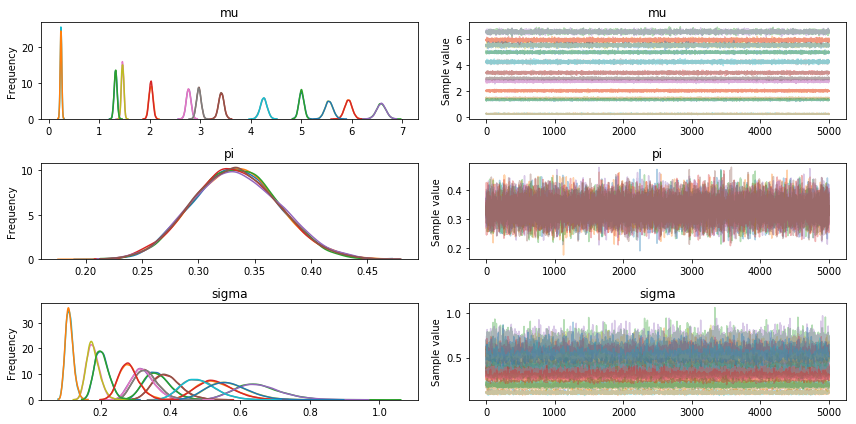

In [63]:
_ = pm.traceplot(trace)

### Prediction time!

Prediction for Bayesian models are slightly different from their frequentist counterpart, they require to evaluate many integrals over the parameters. Given a data point $\mathbf{x} = {x_j}$, we would like to estimate the probability that it belongs to any category $c$. Following the notations in [1], the probability reads:

$$
P(y=c | \mathbf{x}, \mathcal{D}) = P(y=c|\mathcal{D}) \prod_{j=1}^{dims} P(x_j | y=c, \mathcal{D})
$$

The data $\mathcal{D}$ helped us estimate the distribution of the parameter $\mathbf{\mu}$, $\mathbf{\pi}$ and $\mathbf{\sigma}$. We now need to integrate over the values of these parameters:

$$
P(y=c | \mathbf{x}, \mathbf{D}) = \left[\int Cat(y=c|\pi) P(\pi|\mathcal{D}) \mathrm{d}\mathbf{\pi}\right] \prod_{j=1}^{dims} \int Normal(x_j | \mu_{jc}, \sigma_{jc}) P(\mu_{jc}|\mathcal{D}) P(\sigma_{jc} | \mathcal{D}) \mathrm{d} \mu_{jc} \mathrm{d} \sigma_{jc}
$$

which can be evaluated from the samples we previously computed (show).

In [64]:
import itertools as it
import operator
import functools as ft
import scipy.stats

def normalize(array):
    """ Normalize the number in an array to get probabilities.
    """
    return array/np.sum(array)
    

def predict(trace, X):
    """ Predict the probabilities that the data points belong to a class. """
    n_dims = X.shape[1]
    
    predictions = np.array([])
    for x in X:
        normal_probs = scipy.stats.norm(trace['mu'], trace['sigma']).pdf(x)
        per_dim = [np.sum(normal_probs[:,:,i], axis=0)/len(trace['mu']) for i in range(n_dims)]
        a = normalize(ft.reduce(lambda x,y: x*y, per_dim))
        a[np.abs(a) < 0.00001] = 0
        if len(predictions) == 0:
            predictions = a
        else:
            predictions = np.vstack((predictions,a))
    return predictions

pred = predict(trace, iris.data) # Probability the the input belongs to each class
pred_class = np.argmax(pred, axis=1) # Class to which the input is predicted to belong (zero-one loss)
accuracy = sum(np.equal(pred_class, iris.target))/len(iris.data) # Accuracy of the predictions

## Now with pymc3_models

### Features

Let us now re-do the analysis with the `GaussianNaiveBayes` class, and show its features.

In [65]:
# Import the library
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pymc3_models.models.NaiveBayes import GaussianNaiveBayes

First create the model:

In [5]:
N = GaussianNaiveBayes()

Then fit (still using the Iris data). `pymc3_models` uses ADVI inference by default, but you can switch to NUTS by passing `inference_type='nuts'` as a parameter to the `fit` function.

In [68]:
# Load the data and split in train and test set
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit with the training data
N.fit(X_train, y_train)

Average Loss = 394.02: 100%|██████████| 200000/200000 [03:06<00:00, 1074.14it/s]
Finished [100%]: Average Loss = 394.02


GaussianNaiveBayes()

Now you can predict the probabilities that data points belong to each category using the zero-one cost function:

In [69]:
pred_prob = N.predict_proba(X_test)
pred = N.predict(X_test)

And finally, you can compute the accuracy score:

In [72]:
score = N.score(X_test, y_test)
print(score)

0.9111111111111111
